<a href="https://colab.research.google.com/github/spctr01/av/blob/main/AV_job_thon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install lightgbm
!pip install catboost
!pip install xgboost

In [2]:
import pandas as pd 
import pandas_profiling as pp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats

%matplotlib inline
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold , GroupKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_validate, cross_val_score

from lightgbm import LGBMClassifier
import xgboost as xg
import catboost as cb


### change dir

In [3]:
#cd /content/drive/MyDrive/Colab Notebooks/competetion/jobthon

/content/drive/MyDrive/Colab Notebooks/competetion/jobthon


# Read data

In [273]:
train_data = pd.read_csv('train_Df64byy.csv')
test_data = pd.read_csv('test_YCcRUnU.csv')
train_data.drop(['ID'], axis=1, inplace= True)
test_data.drop(['ID'], axis=1, inplace= True)



# **EDA**

In [134]:

train_data.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [135]:
#train_data['City_Code'].unique() = 36
#train_data['Accomodation_Type'].unique() = 2

# train_data['Reco_Insurance_Type'].unique() = 2
#train_data['Is_Spouse'].unique() = 2
#train_data['Health Indicator'].unique() = 10
#train_data['Holding_Policy_Duration'].unique() = 15

#train_data['Holding_Policy_Type'].unique() = 5
#train_data['Reco_Policy_Cat'].unique() = 22



#### Balance of data

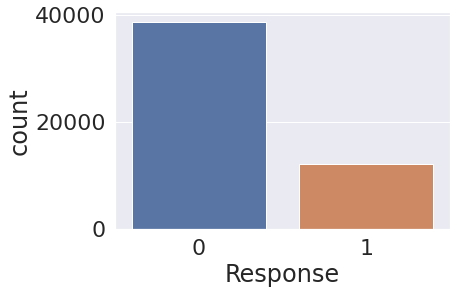

In [136]:
sns.countplot(train_data['Response'])

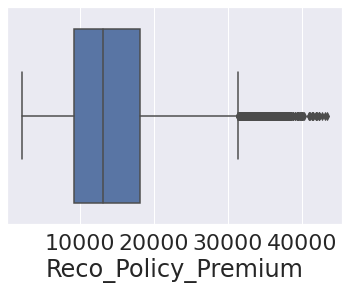

In [137]:
sns.boxplot(x=train_data['Reco_Policy_Premium'])

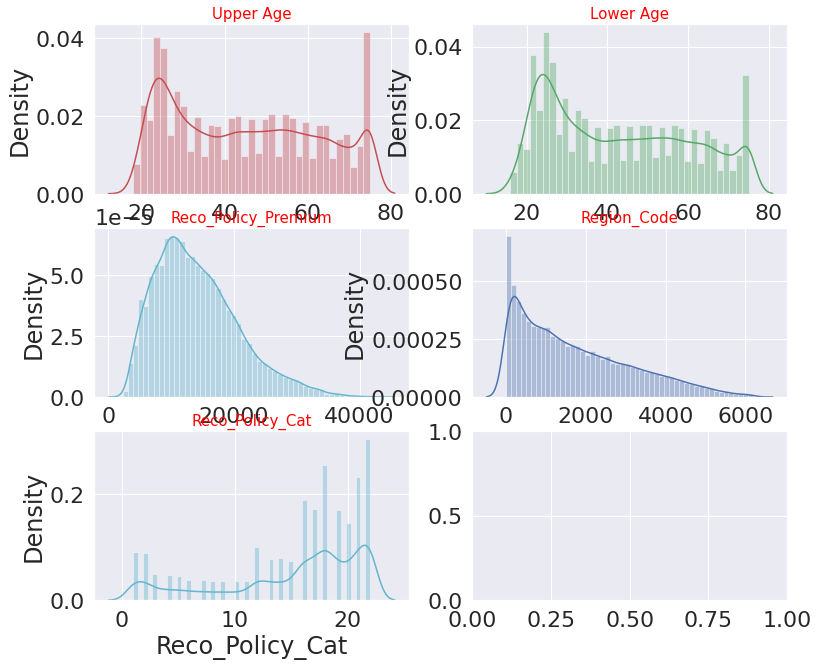

In [138]:
fig, ax = plt.subplots(3,2, figsize =(11,8))
plt.subplots_adjust(bottom=0, right=1, top=1)

ax[0,0].set_title('Upper Age', color='red', fontsize = 15)
sns.distplot(train_data['Upper_Age'],  color="r", ax=ax[0,0])

ax[0,1].set_title('Lower Age', color='red', fontsize = 15)
sns.distplot(train_data['Lower_Age'],  color="g", ax=ax[0,1])

ax[1,0].set_title('Reco_Policy_Premium', color='red', fontsize = 15)
sns.distplot(train_data['Reco_Policy_Premium'],  color="c", ax=ax[1,0])

ax[1,1].set_title('Region_Code', color='red', fontsize = 15)
sns.distplot(train_data['Region_Code'],  color="b", ax=ax[1,1])

ax[2,0].set_title('Reco_Policy_Cat', color='red', fontsize = 15)
sns.distplot(train_data['Reco_Policy_Cat'],  color="c", ax=ax[2,0])

# ax[2,1].set_title('Reco_Policy_Cat', color='red', fontsize = 15)
# sns.distplot(train_data['Reco_Policy_Cat'],  color="b", ax=ax[2,1])

plt.show()

#### pandas profiling

In [139]:
profile = pp.ProfileReport(train_data, title='Pandas Profiling Report', explorative=True)
profile.to_file("profile.html")



Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [140]:
profile.to_notebook_iframe()

# Preprocessing

In [274]:
#remove outlier as seen in boxplot values above 30000
print(train_data.shape)
print(train_data.Reco_Policy_Premium.max())
d = train_data[train_data.Reco_Policy_Premium < 30000]
train_data = d
print(train_data.shape)

(50882, 13)
43350.4
(49651, 13)


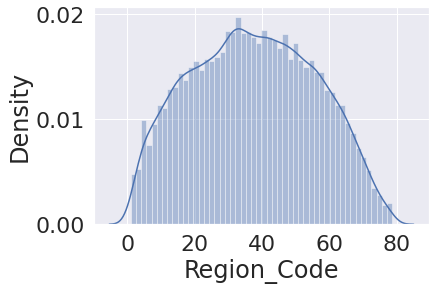

In [275]:
xx = np.sqrt(train_data['Region_Code'])
sns.distplot(xx)

In [276]:
yy = np.log(train_data['Upper_Age'])
kk = np.log(train_data['Upper_Age'])
zz = stats.boxcox(train_data['Upper_Age'])[0]


In [277]:
yl = np.log(train_data['Lower_Age'])
kl = np.sqrt(train_data['Lower_Age'])
zl = stats.boxcox(train_data['Lower_Age'])[0]

In [278]:

print(train_data['Region_Code'].skew())
print(xx.skew())
print(pd.Series(bx).skew())

print('------')
print(train_data['Lower_Age'].skew())
print(kl.skew())
print(yl.skew())
print(pd.Series(zl).skew())
print('------')

print(train_data['Upper_Age'].skew())
print(yy.skew())
print(kk.skew())
print(pd.Series(zz).skew())

0.7980987700906131
0.036478997478906455
-0.17278843709733635
------
0.3625079642732047
0.14027483023961607
-0.09054059777228642
-0.024889914610448538
------
0.25326486432605844
-0.18116536565302055
-0.18116536565302055
-0.05154530680068618


In [279]:
train_data['Region_Code']=xx
# train_data['Lower_Age']=zl
# train_data['Upper_Age']=zz



In [280]:
#train data
train_data['Holding_Policy_Duration'] = train_data['Holding_Policy_Duration'].replace('14+', '15.0')
train_data['Holding_Policy_Duration'] = train_data['Holding_Policy_Duration'].astype(float)
print(train_data['Holding_Policy_Duration'].unique())

#test data
test_data['Holding_Policy_Duration'] = test_data['Holding_Policy_Duration'].replace('14+', '15.0')
test_data['Holding_Policy_Duration'] = test_data['Holding_Policy_Duration'].astype(float)


[15.  1.  3.  5. nan  9. 14.  7.  2. 11. 10.  8.  6.  4. 13. 12.]


In [281]:
#train data
train_data['Health Indicator'] = train_data['Health Indicator'].replace(np.nan, 'none')
print(train_data['Health Indicator'].unique())

#test data
test_data['Health Indicator'] = train_data['Health Indicator'].replace(np.nan, 'none')



['X1' 'none' 'X2' 'X4' 'X3' 'X6' 'X5' 'X8' 'X7' 'X9']


In [282]:
enc = preprocessing.LabelEncoder()
hot_enc = preprocessing.OneHotEncoder()

cols = ['Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse']
hot_cols = ['City_Code', 'Health Indicator', ]

#train data
train_data[cols] = train_data[cols].apply(enc.fit_transform)
df = pd.get_dummies(train_data, columns =hot_cols)

#test_data
test_data[cols] = test_data[cols].apply(enc.fit_transform)
test_df = pd.get_dummies(test_data, columns =hot_cols)




In [283]:
#scale the data
ss = StandardScaler()
scale = ['Reco_Policy_Premium','Holding_Policy_Duration','Holding_Policy_Type','Reco_Policy_Cat', 'Region_Code','Upper_Age','Lower_Age']

#train
train_features= ss.fit_transform(df[scale])
df[scale]= train_features


#test
test_features= ss.fit_transform(test_df[scale])
test_df[scale]= test_features

# ***EXp(test)***

In [153]:
# df1 = df.drop(['Lower_Age'], axis=1)
# test_df = test_df.drop(['Lower_Age'], axis=1)
# #df1['average'] = df[['Upper_Age', 'Lower_Age']].mean(axis=1)
# #df1 = df.drop(['Lower_Age'], axis=1)
# df1 = df.drop(['Upper_Age'], axis=1)


# df = df1
# df.head()


In [154]:
'''
cat boost =0.7624203821656051
[0.76415674 0.76391107 0.76391107 0.75617246 0.75297875]

lgbm
[0.76255988 0.76108586 0.76698194 0.75506695 0.7521189 ]
without
 0.7605384690969834
[[7693   45]
 [2392   47]]

drop lower age

0.7571976024368674
[[7662   24]
 [2447   44]]

drop uper age

0.7555271691068095
[[7652   22]
 [2466   37]]

adding aberage of lower and uper age
0.7586715141986833
[[7670   25]
 [2431   51]]

xgb


'''

'\ncat boost =0.7624203821656051\n[0.76415674 0.76391107 0.76391107 0.75617246 0.75297875]\n\nlgbm\n[0.76255988 0.76108586 0.76698194 0.75506695 0.7521189 ]\nwithout\n 0.7605384690969834\n[[7693   45]\n [2392   47]]\n\ndrop lower age\n\n0.7571976024368674\n[[7662   24]\n [2447   44]]\n\ndrop uper age\n\n0.7555271691068095\n[[7652   22]\n [2466   37]]\n\nadding aberage of lower and uper age\n0.7586715141986833\n[[7670   25]\n [2431   51]]\n\nxgb\n\n\n'

# **Train test split**


In [284]:
x = df.drop('Response',axis = 1)
y = df['Response']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2)


print('training data \n',y_train.value_counts())
print('test data \n',y_test.value_counts())

training data 
 0    30190
1     9530
Name: Response, dtype: int64
test data 
 0    7552
1    2379
Name: Response, dtype: int64


In [285]:
y_train.value_counts()
print(30904/9801)

3.1531476379961227


# Model Buildung and Predicting


In [286]:
sk = StratifiedKFold(n_splits=4)
ssk = StratifiedShuffleSplit(n_splits=4)

# scoring = {'acc': 'accuracy',
#            'prec_macro': 'precision_macro',
#            'rec_micro': 'recall_macro'}


#models
xgb = xg.XGBClassifier()
lgb = LGBMClassifier()
cat = cb.CatBoostClassifier()


# xgb_score= cross_val_score(xgb, x_train, y_train, scoring='f1', cv=sk,n_jobs=-1).mean()
# lgb_score= cross_val_score(lgb, x_train, y_train, scoring='f1', cv=sk, n_jobs=-1).mean()
# cat_score= cross_val_score(cat, x_train, y_train, scoring='f1', cv=sk, n_jobs=-1).mean()
# print(xgb_score,'\n', lgb_score,'\n', cat_score)


# b_xgb_score= cross_val_score(xgb, x_train, y_train, scoring='f1', cv=ssk, n_jobs=-1).mean()
# b_lgb_score= cross_val_score(lgb, x_train, y_train, scoring='f1', cv=ssk, n_jobs=-1).mean()
# b_cat_score= cross_val_score(cat, x_train, y_train, scoring='f1', cv=ssk, n_jobs=-1).mean()
# print(b_xgb_score,'\n', b_lgb_score,'\n', b_cat_score)



**xgb**

0.760145000503474
[[7549    3]
 [2379    0]]


Text(20.5, 0.5, 'Predicted')

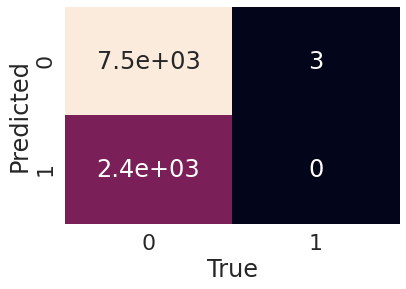

In [287]:
xgb = xg.XGBClassifier()

xgb.fit(x_train,y_train)
print(xgb.score(x_test, y_test))

pred = xgb.predict(x_test)
conf_mat = confusion_matrix(y_test, pred)
print (conf_mat)


#visualise confusion matrix with seaborn heat map
sns.set(font_scale = 2)
sns.heatmap(conf_mat, annot = True, cbar= False)
plt.xlabel('True')
plt.ylabel('Predicted')

**lgbm**

0.7605477796797906
[[7501   51]
 [2327   52]]


Text(20.5, 0.5, 'Predicted')

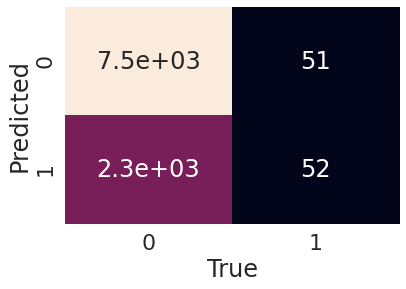

In [288]:
lgb = LGBMClassifier()

lgb.fit(x_train,y_train)
print(lgb.score(x_test, y_test))

pred = lgb.predict(x_test)
conf_mat = confusion_matrix(y_test, pred)
print (conf_mat)


#visualise confusion matrix with seaborn heat map
sns.set(font_scale = 2)
sns.heatmap(conf_mat, annot = True, cbar= False)
plt.xlabel('True')
plt.ylabel('Predicted')

**catboost**

Learning rate set to 0.049626
0:	learn: 0.6775187	total: 15.2ms	remaining: 15.2s
1:	learn: 0.6630112	total: 29.8ms	remaining: 14.9s
2:	learn: 0.6500202	total: 44.8ms	remaining: 14.9s
3:	learn: 0.6384861	total: 59.5ms	remaining: 14.8s
4:	learn: 0.6282555	total: 74.1ms	remaining: 14.7s
5:	learn: 0.6174204	total: 88.3ms	remaining: 14.6s
6:	learn: 0.6094160	total: 103ms	remaining: 14.7s
7:	learn: 0.6021901	total: 118ms	remaining: 14.6s
8:	learn: 0.5956473	total: 133ms	remaining: 14.6s
9:	learn: 0.5901364	total: 147ms	remaining: 14.6s
10:	learn: 0.5846668	total: 162ms	remaining: 14.6s
11:	learn: 0.5803129	total: 177ms	remaining: 14.6s
12:	learn: 0.5764868	total: 193ms	remaining: 14.7s
13:	learn: 0.5726899	total: 208ms	remaining: 14.6s
14:	learn: 0.5690870	total: 223ms	remaining: 14.6s
15:	learn: 0.5656444	total: 237ms	remaining: 14.6s
16:	learn: 0.5627295	total: 252ms	remaining: 14.5s
17:	learn: 0.5604693	total: 267ms	remaining: 14.5s
18:	learn: 0.5581871	total: 281ms	remaining: 14.5s
19:	l

Text(20.5, 0.5, 'Predicted')

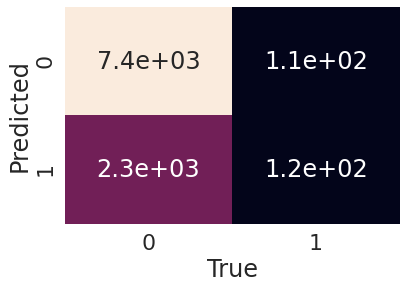

In [289]:
cat = cb.CatBoostClassifier()

cat.fit(x_train,y_train)
print(cat.score(x_test, y_test))

pred = cat.predict(x_test)
conf_mat = confusion_matrix(y_test, pred)
print (conf_mat)


#visualise confusion matrix with seaborn heat map
sns.set(font_scale = 2)
sns.heatmap(conf_mat, annot = True, cbar= False)
plt.xlabel('True')
plt.ylabel('Predicted')

# Submit

In [290]:
pred = lgb.predict(test_df)
s = pd.read_csv('sample_submission_QrCyCoT.csv')
s['Response'] = pred
s.to_csv('sample_submission_QrCyCoT.csv', index = False)
s.head()



,ID,Response
0,50883,0
1,50884,0
2,50885,0
3,50886,0
4,50887,0


In [ ]:
'''
with norm skew(1)
cat  0.7687040580002014
lgbm  0.7679991944416473
'''